In [1]:
import os, math, json
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.python.keras.layers import Input, LSTM, Bidirectional, Dense, Embedding

import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
# init GPU

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

Found GPU at: /device:GPU:0


In [3]:

baseDIR = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/'
for dirname, _, filenames in os.walk(baseDIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# Any results you write to the current directory are saved as output.

trainDir = baseDIR + 'train'
testDir = baseDIR + 'test'
validationDir = baseDIR + 'val'


/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1051-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person498_bacteria_2102.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/IM-0025-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA/person3_virus_16.jpeg


In [4]:
IMAGE_SIZE=[192,192]
BATCH_SIZE=64
EPOCHS=10

CLASSES=['bacteria','virus','normal']


validation_steps = 30
steps_per_epoch = 30


In [5]:
def plot_images(path, max_images=6):
  amount = 0
  fig = plt.figure(figsize=(12, 6))

  for file in os.listdir(path):
    if file.endswith('.jpeg'):
      if amount == max_images:
        break

      img = mpimg.imread(os.path.join(path, file))
      plt.subplot(231+amount)
      if str.__contains__(file, '_'):
        plt.title(file.split('_')[1])
      else:
        plt.title('normal')
      imgplot = plt.imshow(img)

      amount += 1
        

### Pneumonia Image

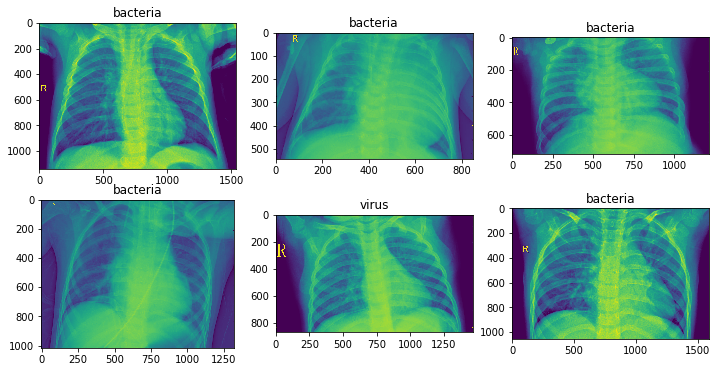

In [6]:
plot_images(trainDir+"/PNEUMONIA")

### Normal Image

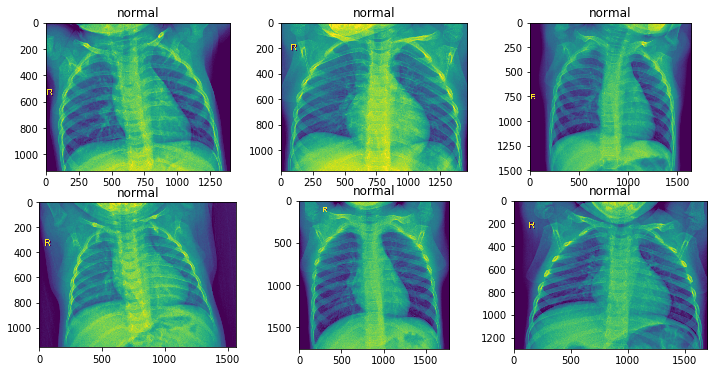

In [7]:
plot_images(trainDir +'/NORMAL')

In [8]:
rescale = 1./255.0
target_size = (150, 150)
batch_size = 32
class_mode = 'categorical'

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale
)
train_generator = train_datagen.flow_from_directory(
    trainDir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    validationDir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    testDir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [9]:
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)
model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

87916544/87910968 [==============================] - 4s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
___________________________

In [10]:
with tf.device('/device:GPU:0'):
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=5,
        verbose=1,
        validation_data=validation_generator,
        validation_steps=len(validation_generator)
    )


Epoch 1/5
163/163 [==============================] - 107s 654ms/step - loss: 0.3957 - accuracy: 0.8556 - val_loss: 1.3899 - val_accuracy: 0.7500
Epoch 2/5
163/163 [==============================] - 85s 524ms/step - loss: 0.2583 - accuracy: 0.8974 - val_loss: 4.6137 - val_accuracy: 0.5625
Epoch 3/5
163/163 [==============================] - 86s 525ms/step - loss: 0.2530 - accuracy: 0.9045 - val_loss: 2.1492 - val_accuracy: 0.6250
Epoch 4/5
163/163 [==============================] - 86s 526ms/step - loss: 0.2673 - accuracy: 0.8913 - val_loss: 5.0814 - val_accuracy: 0.5000
Epoch 5/5
163/163 [==============================] - 86s 526ms/step - loss: 0.2466 - accuracy: 0.8984 - val_loss: 1.9280 - val_accuracy: 0.6250


In [11]:
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])

624/624 [==============================] - 16s 26ms/step
Loss: 0.0002083561266772449
Accuracy: 0.6810897588729858


In [12]:
model.save('my_model.h5')
# new_model = keras.models.load_model('my_model.h5')